In [1]:
import numpy as np          # fundamental package for scientific computing
import glob                 # return all file paths that match a specific pattern
import matplotlib.pyplot as plt 
import os                   # to interact with the operating system
import csv                  # to save indices

In [2]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/')+'timeseries/*time_series.npy')

hist_end = (2014-1850)*12
time_annual = np.arange(1850,1850+(hist_end/12))

In [3]:
raw_files

['/home/innag3580/phase1_CONDA/timeseries/OSNAPwest_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/bsf_min_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/spgy_dept_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/rapi_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/maxi_dept_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/maxi_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/OSNAPeast_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/spgy_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/rapi_dept_time_series.npy']

In [4]:
def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# find the corresponding number in the bsf list
def find_corresponding_bsf_number(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order_bsf.txt'), 'r') as file:
        bsf_list = file.readlines()
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    bsf_dict = {filename.split()[1]: int(filename.split()[0]) for filename in bsf_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  # Extract the filename part
            break
    bsf_filename = vvel_filename.replace("vvel", "bsf")
    return bsf_dict[bsf_filename], bsf_filename

# Perform change point analysis on SPG dens

In [5]:
h=7 # spgy_dens_time_series

# Load your data
signals = np.load(raw_files[h])
signals = signals[:hist_end]

# Get the number of time series
num_time_series = signals.shape[1]

# Define the window size
window_size = 40
# Define the duration threshold
duration_threshold = 20
# Compute entire period
period = window_size + duration_threshold

# Define the threshold factor
threshold_multiple = 3

# Define a dictionary to store criteria_indices for each i value
criteria_indices_dict = {}

# Iterate over each time series
for i in range(num_time_series):
    # Select time series
    signal = signals[:, i]

    # Calculate the annual means by averaging the values in each row
    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)
    
    # prepare data
    criteria_indices = []
    
    # Start after first window size
    for j in range(window_size, len(annual_means)-duration_threshold):
        
        # Compute mean and std of compariosn window
        window = annual_means[j-window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)

        # compute mean of range of interest
        threshold = annual_means[j:j+duration_threshold]
        avg_threshold = np.mean(threshold)
        
        # Check if the std is above the threshold
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):

            if len(criteria_indices) == 0:
                criteria_indices.append(j)
                
            elif j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
                
        # Save criteria_indices in the dictionary
        criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

# Open the 'events_dens_spg.csv' file for writing ('w' mode) with newline='' to handle line endings.
with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    # Define the field names for the CSV file.
    fieldnames = ['Index', 'Values']
    # Create a CSV DictWriter object using the specified field names.
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    # Write the header row to the CSV file.
    writer.writeheader()
    # Iterate through the 'result' iterable, assuming it contains pairs of 'index' and 'values'.
    for index, values in result:
        # Write a new row to the CSV file with 'Index' and the first element of 'values'.
        writer.writerow({'Index': index, 'Values': values[0]})

# Plot members with events and indicate criteria

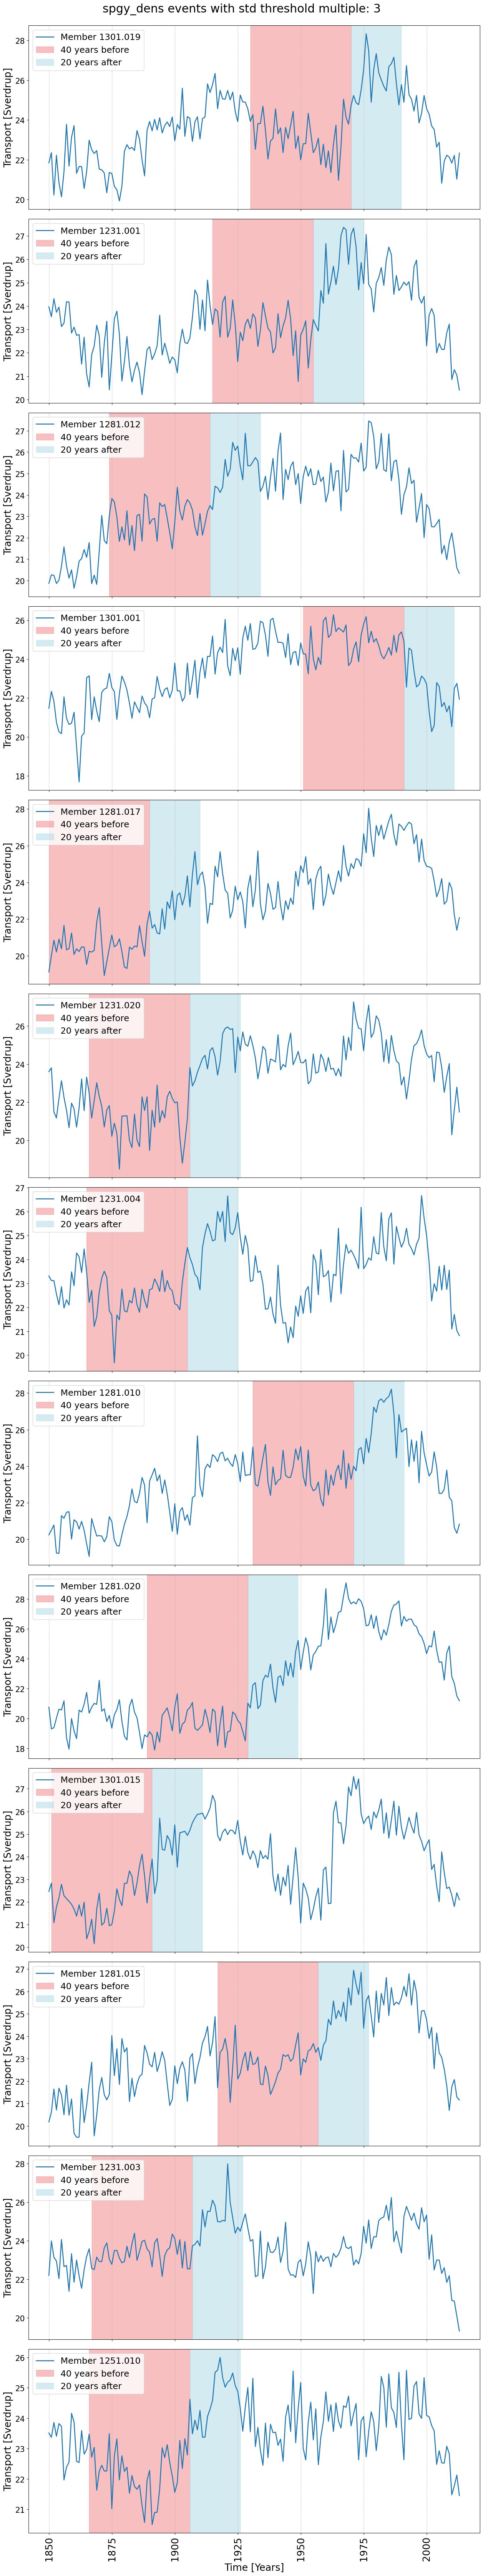

In [6]:

# Calculate the number of subplots needed
num_subplots = len(result)

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 6 * num_subplots), sharex=True)

# Iterate over each signal
for k, (index, values) in enumerate(result):
    # Select time series
    signal = signals[:, index]

    # Calculate the annual means by averaging the values in each row
    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)
    
    # Find file name
    file_name = find_corresponding_file_name(index)[5:-3]

    # Plot time series and ranges in the ith subplot
    axs[k].plot(time_annual, annual_means, label=f'Member {file_name}', linewidth=2)
    start = values[0] + 1850
    end = values[0] + duration_threshold + 1850
    axs[k].axvspan(start - window_size, start, alpha=0.5, color='lightcoral', label=str(window_size)+' years before')
    axs[k].axvspan(start, end, alpha=0.5, color='lightblue', label=str(duration_threshold)+' years after')

    # Add trimmings
    axs[k].legend(fontsize=18, loc='upper left')
    axs[k].set_ylabel('Transport [Sverdrup]', fontsize=20)
    axs[k].yaxis.set_tick_params(labelsize=16)

# Set x-ticks and labels only on the first and last subplot
axs[-1].set_xticks(time_annual[::25])
axs[-1].set_xlabel('Time [Years]', fontsize=20)
axs[-1].set_xticklabels([int(x) for x in time_annual[::25]], fontsize=20, rotation=90)  # Set x-tick labels as integers with fontsize 20 and rotation 90 degrees

# Add x-grid lines through all plots
for ax in axs:
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Add a large title at the top
fig.suptitle(raw_files[h][40:-16]+' events with std threshold multiple: '+str(threshold_multiple), fontsize=24)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the figure
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'raw_events_'+raw_files[h][40:-16]+'.png', bbox_inches='tight', dpi=300)

# Check other metrics of eventful members if there are event as well

In [196]:
#for g in range(len(raw_files)):
#    if g == h:
#        continue  # Skip event metric

g=8

# Load data
signals = np.load(raw_files[g])
signals = signals[:hist_end]
        
# Get number of time series
num_time_series = signals.shape[1]

# Define before window size
window_size = 40
# Define after window size
duration_threshold = 20
# Compute total period
period = window_size + duration_threshold

# Define threshold factor
threshold_multiple = 2

# Define a dictionary to store events
events_dict = {}

# Iterate over time series with events in dens spgy
for l,(index, values) in enumerate(result):
    
    if 'dept' not in raw_files[g].lower() and 'dens' not in raw_files[g].lower():
        index, file_name = find_corresponding_bsf_number(index)
    
    # Select time series
    signal = signals[:, index]

    # Calculate annual means
    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)

    criteria_indices = []

    # Start after first window size
    for m in range(window_size, len(annual_means)-duration_threshold):

        # Compute mean and std of compariosn window
        window = annual_means[m-window_size:m]
        std_window = np.std(window)
        avg_window = np.mean(window)

        # compute mean of range of interest
        threshold = annual_means[m:m+duration_threshold]
        avg_threshold = np.mean(threshold)

        # Check if the std is above the threshold
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):

            if len(criteria_indices) == 0:
                criteria_indices.append(m)

            elif k >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(m)

    # Save events in dictionary
    events_dict[l] = criteria_indices

In [197]:
events_dict

{0: [],
 1: [],
 2: [57],
 3: [61],
 4: [43],
 5: [52],
 6: [51],
 7: [119],
 8: [82],
 9: [41],
 10: [],
 11: [56],
 12: [56]}

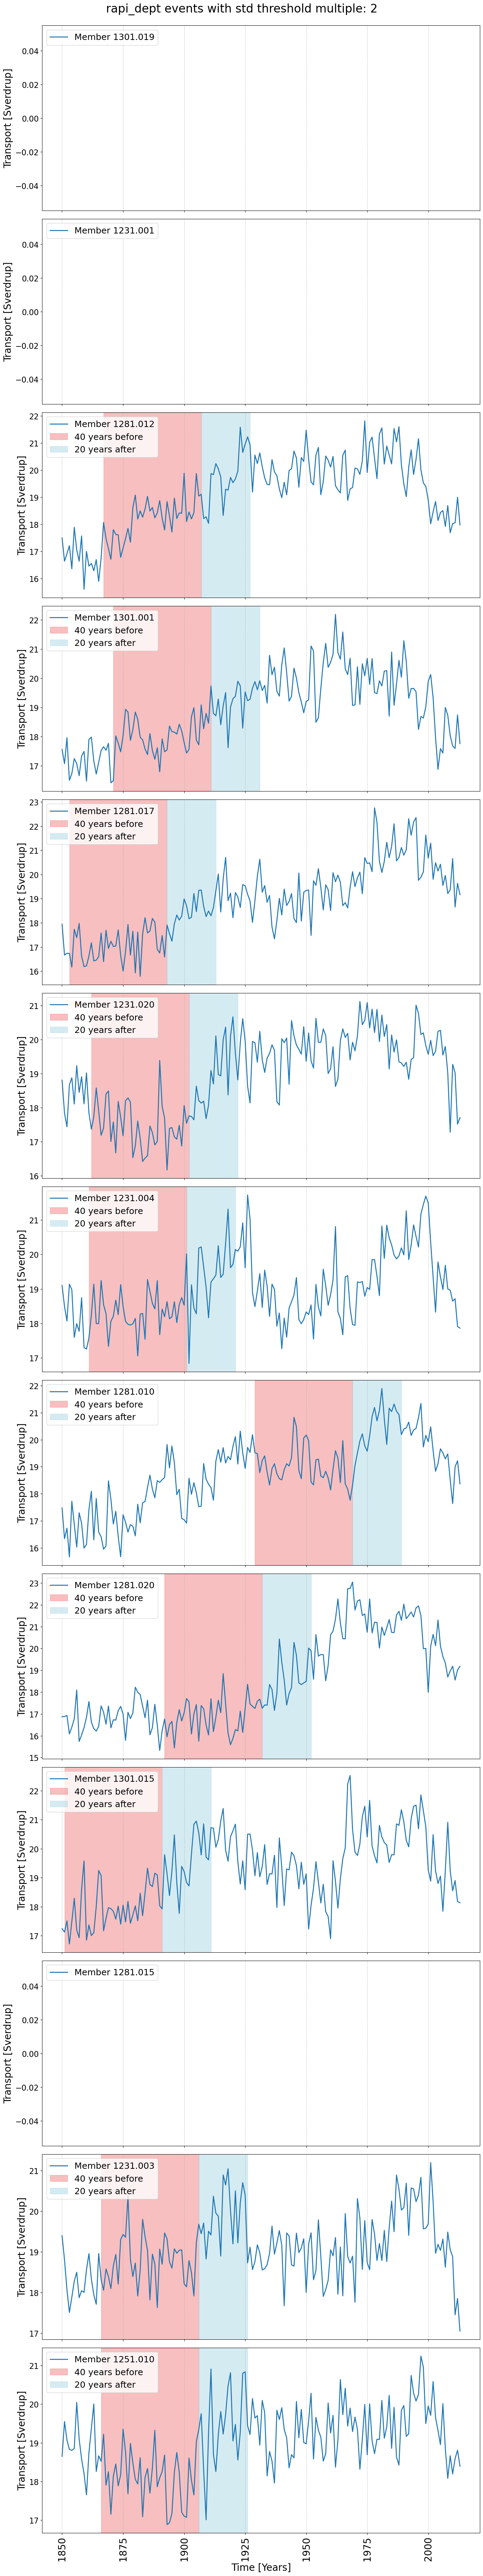

In [199]:
# Calculate the number of subplots needed
num_subplots = len(result)

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 6 * num_subplots), sharex=True)

# Iterate over time series with events in dens spgy
for n,(index, values) in enumerate(result):
    
    # Find file name
    if 'dept' not in raw_files[g].lower() and 'dens' not in raw_files[g].lower():
        index, file_name = find_corresponding_bsf_number(index)
        file_name = file_name[5:-3]
    else:
        file_name = find_corresponding_file_name(index)[5:-3]
    
    # Select time series
    signal = signals[:, index]

    # Calculate the annual means by averaging the values in each row
    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)

    # Plot time series and if allicable ranges in the jth subplot
    axs[n].plot(time_annual, annual_means, label=f'Member {file_name}', linewidth=2)
    if events_dict[n]:
        start = events_dict[n][0] + 1850
        end = events_dict[n][0] + duration_threshold + 1850
        axs[n].axvspan(start - window_size, start, alpha=0.5, color='lightcoral', label=str(window_size)+' years before')
        axs[n].axvspan(start, end, alpha=0.5, color='lightblue', label=str(duration_threshold)+' years after')

    # Add trimmings
    axs[n].legend(fontsize=18, loc='upper left')
    axs[n].set_ylabel('Transport [Sverdrup]', fontsize=20)
    axs[n].yaxis.set_tick_params(labelsize=16)

# Set x-ticks and labels only on the first and last subplot
axs[-1].set_xticks(time_annual[::25])
axs[-1].set_xlabel('Time [Years]', fontsize=20)
axs[-1].set_xticklabels([int(x) for x in time_annual[::25]], fontsize=20, rotation=90)  # Set x-tick labels as integers with fontsize 20 and rotation 90 degrees

# Add x-grid lines through all plots
for ax in axs:
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Add a large title at the top
fig.suptitle(raw_files[g][40:-16]+' events with std threshold multiple: '+str(threshold_multiple), fontsize=24)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the figure
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'raw_events_'+raw_files[g][40:-16]+'.png', bbox_inches='tight', dpi=300)